In [42]:
import numpy as np
import awkward as ak  # Now needed for reading the data
import uproot
import matplotlib.pyplot as plt
import vector

# # 4b or bbaa
# final_state = "4b"
# batch = "0"

# # File paths: left plot = signal, right plot = background
# FILE_PATH_SIGNAL = f"/vols/cms/us322/events_{final_state}/02b_final_events_{final_state}/signal_sm/batch_{batch}/run_01_decayed_1/tag_1_pythia8_events_delphes.root"
# FILE_PATH_BACKGROUND = f"/vols/cms/us322/events_{final_state}/02b_final_events_{final_state}/background/batch_{batch}/run_01/tag_1_pythia8_events_delphes.root"

FILE_PATH_SIGNAL = f"/vols/cms/us322/testing_delphes/signal_sm/batch_0/run_01_decayed_1/tag_1_pythia8_events_delphes.root"
FILE_PATH_BACKGROUND = f"/vols/cms/us322/testing_delphes/background/batch_0/run_01/tag_1_pythia8_events_delphes.root"

# Read only the GenJet branches we need to avoid the data corruption error
branches_to_read = [
    "GenJet/GenJet.PT",
    "GenJet/GenJet.Eta",
    "GenJet/GenJet.Phi",
    "GenJet/GenJet.BTag",
    "GenJet/GenJet.Mass"
]

In [43]:
# def compute_candidate_kinematics(pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2):
#     """
#     Computes candidate four-vector kinematics from two jet inputs.
#     """
#     E1  = pt1 * np.cosh(eta1)
#     px1 = pt1 * np.cos(phi1)
#     py1 = pt1 * np.sin(phi1)
#     pz1 = pt1 * np.sinh(eta1)

#     E2  = pt2 * np.cosh(eta2)
#     px2 = pt2 * np.cos(phi2)
#     py2 = pt2 * np.sin(phi2)
#     pz2 = pt2 * np.sinh(eta2)

#     E  = E1 + E2
#     px, py, pz = px1 + px2, py1 + py2, pz1 + pz2

#     eps = 1e-12
#     candidate_pt  = np.sqrt(px**2 + py**2)
#     candidate_p = np.sqrt(px**2 + py**2 + pz**2)
#     candidate_phi = np.arctan2(py, px)
#     candidate_eta = 0.5 * np.log((candidate_p+pz + eps)/(candidate_p-pz + eps))
#     candidate_mass = np.sqrt(max(E**2 - (px**2+py**2+pz**2), 0))
#     candidate_rapidity = 0.5 * np.log((E+pz)/(E-pz)) if (E-pz)!=0 else 0.0

#     return candidate_mass, candidate_pt, (E,px,py,pz), candidate_eta, candidate_phi, candidate_rapidity, candidate_p


In [44]:
def compute_candidate_kinematics(pt1, pt2, eta1, eta2, phi1, phi2, mass1, mass2):

    j1 = vector.obj(pt=pt1, eta=eta1, phi=phi1, mass=mass1)
    j2 = vector.obj(pt=pt2, eta=eta2, phi=phi2, mass=mass2)

    candidate = j1+j2

    return candidate.mass, candidate.pt

In [45]:
# Load arrays for signal and background
with uproot.open(FILE_PATH_SIGNAL) as f_sig:
    arrays_sig = f_sig["Delphes"].arrays(branches_to_read, library="ak")
with uproot.open(FILE_PATH_BACKGROUND) as f_bkg:
    arrays_bkg = f_bkg["Delphes"].arrays(branches_to_read, library="ak")

# Quick inspection
print("Signal:")
print(f"  Number of events: {len(arrays_sig)}")
print(f"  Available branches: {list(arrays_sig.fields)}")
print("Background:")
print(f"  Number of events: {len(arrays_bkg)}")
print(f"  Available branches: {list(arrays_bkg.fields)}")


Signal:
  Number of events: 1000
  Available branches: ['GenJet/GenJet.PT', 'GenJet/GenJet.Eta', 'GenJet/GenJet.Phi', 'GenJet/GenJet.BTag', 'GenJet/GenJet.Mass']
Background:
  Number of events: 5000
  Available branches: ['GenJet/GenJet.PT', 'GenJet/GenJet.Eta', 'GenJet/GenJet.Phi', 'GenJet/GenJet.BTag', 'GenJet/GenJet.Mass']


In [46]:
def collect_candidate_masses(arrays):
    cand1_masses = []
    cand2_masses = []

    for event_idx in range(len(arrays)):
        pts = arrays["GenJet/GenJet.PT"][event_idx]
        etas = arrays["GenJet/GenJet.Eta"][event_idx]
        phis = arrays["GenJet/GenJet.Phi"][event_idx]
        btag_scores = arrays["GenJet/GenJet.BTag"][event_idx]
        masses = arrays["GenJet/GenJet.Mass"][event_idx]

        pts = np.array(pts)
        etas = np.array(etas)
        phis = np.array(phis)
        btag_scores = np.array(btag_scores)
        masses = np.array(masses)

        if len(pts) < 4:
            continue

        jet_indices = np.argsort(btag_scores)[::-1][:4]
        jets = [(pts[i], etas[i], phis[i], masses[i]) for i in jet_indices]

        pairings = [((0, 1), (2, 3)), ((0, 2), (1, 3)), ((0, 3), (1, 2))]
        pairing_results = []

        for (pair1_jet1, pair1_jet2), (pair2_jet1, pair2_jet2) in pairings:
            m_pair1, pt_pair1 = compute_candidate_kinematics(
                jets[pair1_jet1][0], jets[pair1_jet2][0],
                jets[pair1_jet1][1], jets[pair1_jet2][1],
                jets[pair1_jet1][2], jets[pair1_jet2][2],
                jets[pair1_jet1][3], jets[pair1_jet2][3]
            )
            m_pair2, pt_pair2 = compute_candidate_kinematics(
                jets[pair2_jet1][0], jets[pair2_jet2][0],
                jets[pair2_jet1][1], jets[pair2_jet2][1],
                jets[pair2_jet1][2], jets[pair2_jet2][2],
                jets[pair2_jet1][3], jets[pair2_jet2][3]
            )

            if pt_pair2 > pt_pair1:
                m1, m2 = m_pair2, m_pair1
                pt1, pt2 = pt_pair2, pt_pair1
                H1_jet1, H1_jet2, H2_jet1, H2_jet2 = pair2_jet1, pair2_jet2, pair1_jet1, pair1_jet2
            else:
                m1, m2 = m_pair1, m_pair2
                pt1, pt2 = pt_pair1, pt_pair2
                H1_jet1, H1_jet2, H2_jet1, H2_jet2 = pair1_jet1, pair1_jet2, pair2_jet1, pair2_jet2

            pair_factor = 125 / 120
            dHH = abs(m1 - pair_factor * m2) / np.sqrt(1 + pair_factor**2)
            RHH = np.sqrt((m1 - 125) ** 2 + (m2 - 120) ** 2)
            pairing_results.append((dHH, RHH, (H1_jet1, H1_jet2, H2_jet1, H2_jet2)))

        pairing_results.sort(key=lambda x: x[0])
        _, RHH, best_indices = pairing_results[0]

        cand1_mass, cand1_pt = compute_candidate_kinematics(
            jets[best_indices[0]][0], jets[best_indices[1]][0],
            jets[best_indices[0]][1], jets[best_indices[1]][1],
            jets[best_indices[0]][2], jets[best_indices[1]][2],
            jets[best_indices[0]][3], jets[best_indices[1]][3]
        )

        cand2_mass, cand2_pt = compute_candidate_kinematics(
            jets[best_indices[2]][0], jets[best_indices[3]][0],
            jets[best_indices[2]][1], jets[best_indices[3]][1],
            jets[best_indices[2]][2], jets[best_indices[3]][2],
            jets[best_indices[2]][3], jets[best_indices[3]][3]
        )

        cand1_masses.append(cand1_mass)
        cand2_masses.append(cand2_mass)

    return np.array(cand1_masses), np.array(cand2_masses)

sig_cand1, sig_cand2 = collect_candidate_masses(arrays_sig)
bkg_cand1, bkg_cand2 = collect_candidate_masses(arrays_bkg)

print(f"Processed (signal) {len(sig_cand1)} events")
print(f"Processed (background) {len(bkg_cand1)} events")


Processed (signal) 959 events
Processed (background) 4844 events


Signal means: m1=108.97 GeV, m2=111.41 GeV
Background means: m1=95.16 GeV, m2=93.74 GeV


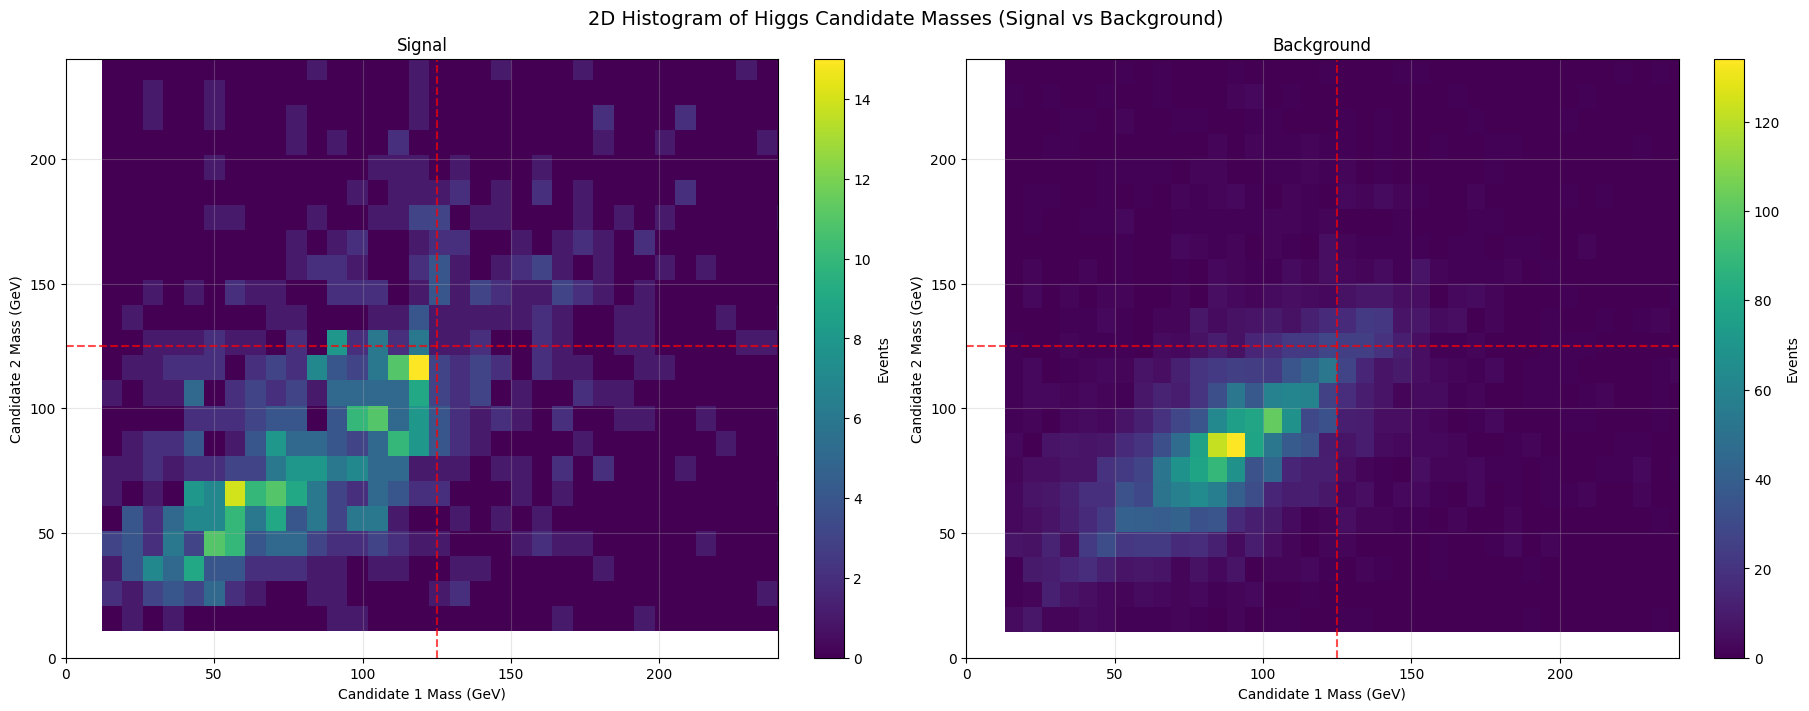

In [47]:
# Side-by-side 2D histograms (Signal | Background) with higher resolution
fig, axes = plt.subplots(1, 2, figsize=(18, 7), constrained_layout=True)

# Signal
h1 = axes[0].hist2d(sig_cand1, sig_cand2, bins=100, cmap='viridis')
axes[0].set_xlim(0, 240)
axes[0].set_ylim(0, 240)
axes[0].set_xlabel('Candidate 1 Mass (GeV)')
axes[0].set_ylabel('Candidate 2 Mass (GeV)')
axes[0].set_title('Signal')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=125, color='red', linestyle='--', alpha=0.7)
axes[0].axhline(y=125, color='red', linestyle='--', alpha=0.7)
fig.colorbar(h1[3], ax=axes[0], label='Events')

# Background
h2 = axes[1].hist2d(bkg_cand1, bkg_cand2, bins=100, cmap='viridis')
axes[1].set_xlim(0, 240)
axes[1].set_ylim(0, 240)
axes[1].set_xlabel('Candidate 1 Mass (GeV)')
axes[1].set_ylabel('Candidate 2 Mass (GeV)')
axes[1].set_title('Background')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=125, color='red', linestyle='--', alpha=0.7)
axes[1].axhline(y=125, color='red', linestyle='--', alpha=0.7)
fig.colorbar(h2[3], ax=axes[1], label='Events')

fig.suptitle('2D Histogram of Higgs Candidate Masses (Signal vs Background)', fontsize=14)
plt.savefig('higgs_candidate_masses_signal_vs_background_highres.pdf', dpi=200)

print(f"Signal means: m1={np.mean(sig_cand1):.2f} GeV, m2={np.mean(sig_cand2):.2f} GeV")
print(f"Background means: m1={np.mean(bkg_cand1):.2f} GeV, m2={np.mean(bkg_cand2):.2f} GeV")


## Raw Masses

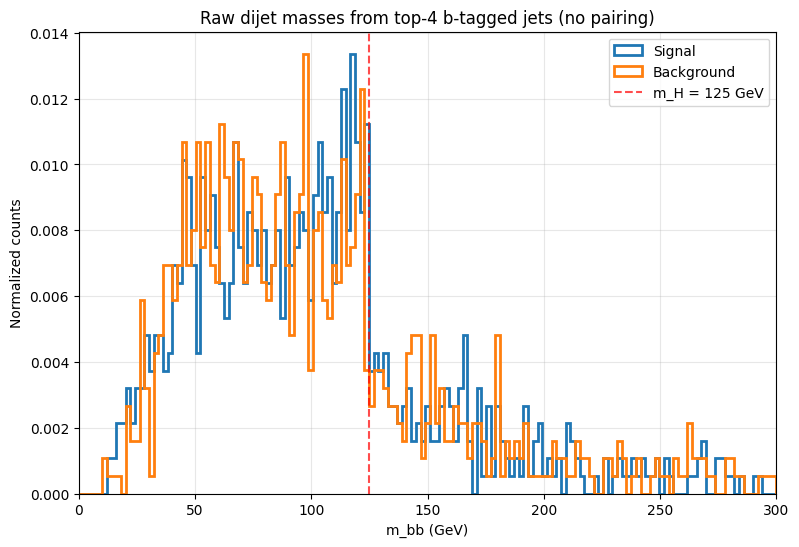

In [48]:
# Plot overlaid 1D histograms of raw dijet masses (no HH pairing)
plt.figure(figsize=(9,6))

bins = np.linspace(0, 300, 150)
plt.hist(sig_cand1, bins=bins, histtype='step', linewidth=2, label='Signal', color='tab:blue', density=True)
plt.hist(sig_cand2, bins=bins, histtype='step', linewidth=2, label='Background', color='tab:orange', density=True)

plt.axvline(125, color='red', linestyle='--', alpha=0.7, label='m_H = 125 GeV')
plt.xlabel('m_bb (GeV)')
plt.ylabel('Normalized counts')
plt.title('Raw dijet masses from top-4 b-tagged jets (no pairing)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 300)

plt.savefig('raw_mbb_signal_vs_background.pdf', dpi=200)
